# Beispiel 11.3: Reversible, exotherme Reaktion im Rohrreaktor
Bearbeitet von Amke Wiesner

Dieses Beispiel befindet sich im Lehrbuch auf den Seiten 148 - 150. Die Nummerierung der verwendeten Gleichungen entspricht der Nummerierung im Lehrbuch.

# Code

Zunächst werden die benötigten Pakete importiert. Im Anschluss werden die gegebenen Werte in Variablen angelegt. Die Werte entstammen dem Beispiel 9.4 des Lehrbuchs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
DRH_ref = -75.3e3       # J/mol       Reaktionsenthalpie bei Referenztemp.
DRG_ref = -14.13e3      # J/mol       freie Reaktionsenthalpie
DT_ad   = 200           # K           adiabatische Temperaturdifferenz
T_a     = 50 + 273      # K           effektive Kühltemperatur
T_ref   = 298           # K           Referenztemperatur
T_e     = 50 + 273      # K           Eintrittstemperatur (aus Grafik 11.3)
T_k     = 50 + 273      # K           Kühltemperatur (aus Grafik 11.3)
R       = 8.314         # J/(mol K)   universelle Gaskonstante
c1_e    = 1000          # mol/m³      Zulaufkonzentration Komp. A1
nu1     = -1            # -           stöchiometrischer Koeffizient Komp. A1

tau_av      = 15        # s           mittlere Verweilzeit
k0_forward  = 34e6 /60  # 1/s         Frequenzfaktor Hinreaktion
Ea_forward  = 48.9e3    # J/mol       Aktivierungsenergie Hinreaktion

Die isotherme, die adabatische und zwei verschiedene polytrope Reaktiosnführungen werden durch Variation der Stanton-Zahl abgebildet.

In [3]:
St_isotherm    = 0
St_poly_1      = 0.73
St_poly_2      = 2.5
St_adiabatisch = 100000
Stanton = [St_isotherm, St_poly_1, St_poly_2, St_adiabatisch]

Festlegen des Zeitbereichs zur Lösung des Systems aus Differentialgleichungen:

In [4]:
t = np.linspace(0, 100, 1001)         # s  Verweilzeit  

Ebenso wird direkt zu Beginn ein Temperaturbereich festgelegt, in dem Berechnungen durchgeführt werden sollen und der später in der grafischen Darstellung aufgegriffen wird.

In [5]:
T_range = np.linspace(0 + 273, 150 +273, 1501)  # K

## Berechnen der Gleichgewichtskonstante

Die temperaturabhängige Gleichgewichtskonstante *K(T)* wird mit Hilfe des Verhältnisses aus $K(T) / K(T_{ref})$ berechnet. Die Formel und Details zur Herleitung finden sich im Beispiel 9.4 des Lehrbuchs. Implementiert wird an dieser Stelle folgender Ausdruck:

\begin{equation*}
K(T) = K(T_\text{ref}) \cdot exp \bigg[ \frac{- \Delta_\text{R} H^\ominus _ \text{ref}}{R} \cdot \bigg( \frac{1}{T} - \frac{1}{T_\text{ref}} \bigg) \bigg]
\end{equation*}

In [6]:
def K(T):
    return K_ref * np.exp(-DRH_ref/R * (1/T - 1/T_ref))

Die Gleichgewichtskonstante bei Referenztemperatur nimmt einen konstanten Wert an, der nach Glg. (4.12) berechnet wird.

In [7]:
K_ref = np.exp(- DRG_ref / (R*T_ref))   # Glg. (4.12)
print('K_ref = ', round(K_ref,4))

K_ref =  299.8146


Nun werden die Funktionen für die Geschwindigkeitskonstanten der Hin- und Rückreaktion angelegt. Die Geschwindigkeitskonstante der Hinreaktion *k_forward* wird auf Basis des Arrhenius-Ansatzes nach Glg. (5.7) berechnet:
\begin{equation*}
k_+ = k_\text{0,+} \cdot exp \bigg( \frac{-E_\text{A}}{R \cdot T} \bigg)
\end{equation*}

Basierend auf Glg. (9.16c) wird die Geschwindigkeitskonstante für die Rückreaktion *k_backward* berechnet:
\begin{equation*}
k_- = \frac{k_+}{K(T)}
\end{equation*}

In [8]:
def k_forward(T):          # Arrhenius-Ansatz
    return k0_forward * np.exp(-Ea_forward / (R * T))

def k_backward(T):         # Glg. 9.16c
    return k_forward(T) / K(T)

Das folgende Gleichungssystem aus differentiellen Material- und Energiebilanzen wird gelöst. Die Reaktionsführungen werden durch die verschiedenen Stanton-Zahlen eingebunden.

Die Basis für die Materialbilanz bildet die Glg. (11.1a). Sie wird für den stationären Fall unter Verwendung der Glg. (11.3b) und (11.5c) umgeformt.
\begin{equation*}
\frac{df}{d \tau} = \nu_1 \cdot r \cdot \frac{1}{Da_\text{I}}
\end{equation*}

Der Energiebilanz liegt die Glg. (11.1b) zugrunde. Auch diese wird mit der Glg. (11.3b) und den dimensionslosen Kennzahlen in Glg. (11.5) für den stationären Fall umgeformt.
\begin{equation*}
\frac{dT}{d \tau} = \frac{\Delta T_\text{ad}}{c_\text{1,e}} \cdot r - \frac{St}{\overline{\tau}} \cdot (T - \overline{T}_\text{K})
\end{equation*}

In [9]:
U_save = [0,0,0,0]
T_save = [0,0,0,0]
t_save = [0,0,0,0]
counter  = 0
for St in Stanton:
    
    f0, T0 = 1.0, T_e
    
    def balance(y, t):
        f, T = y
        
        r = k_forward(T) * c1_e * f - k_backward(T) * c1_e * (1-f)    # Glg. im Bsp. 11.3
        dfdt = nu1 * (r) * 1/c1_e                                     # Materialbilanz
        dTdt = DT_ad/c1_e * (r) - St/tau_av * (T - T_k)               # Energiebilanz
        
        return dfdt, dTdt
    
    # Anfangsbedingungen
    y0 = f0, T0
    
    # Lösen
    solve = odeint(balance, y0, t)
    f, T  = solve.T
    
    U = 1 - f
    
    # Speichern 
    U_save[counter] = U
    T_save[counter] = T
    t_save[counter] = t
    
    counter = counter + 1

Wie bereits im Beispiel 9.4 soll auch hier der Umsatzgrad in Abhängigkeit von der Temperatur betrachtet werden. Zunächst wird der Verlauf des Umsatzgrades im Gleichgewichtszustand berechnet. Dazu wird die Glg. (9.17) verwendet. Der Verlauf des Umsatzgrades bei verschiedenen Reaktionsgeschwindigkeiten wird nach Glg. (9.31) berechnet. Eine detaillierte Herleitung ist im Beispiel 9.4 im Lehrbuch zu finden.

In [10]:
def U_eq(T):                     # Glg. (9.17)
    return K(T)/( K(T)+1 )

def U_r(T,r):                    # Glg. (9.31)
    return ( k_forward(T) * c1_e - r )/ ( c1_e * (k_forward(T) + k_backward(T)) )

Zudem ist von Interesse, wie sich der maximale Umsatzgrad bei verschiedenen Reaktionsgeschwindigkeiten verändert. Dies wird in der $\Gamma$-Kurve dargestellt. In einer *for*-Schleife werden verschiedene Werte für die Reaktionsgeschwindigkeit eingesetzt und der Verlauf des Umsatzgrades mit Hilfe der Funktion *U_r* berechnet. Für jede Reaktionsgeschwindigkeit wird der maximale Umsatzgrad und die Temperatur, bei der dieser erreicht wird, bestimmt und gespeichert.

In [11]:
# Gamma-Kurve berechnen (Verbindet die Maxima von U_r)
r_range = np.linspace(0, 100, 1001)

gamma  = np.empty(0)
T_gamma = np.empty(0)

for r in r_range:
    
    U       = U_r(T_range, r)
    U_max   = np.max(U)
    gamma   = np.append(gamma, U_max)
    
    T_pos   = np.argwhere(U == U_max)[0,0] 
    T_pos   = T_range[T_pos]
    T_gamma = np.append(T_gamma, T_pos)

In einem weiteren Diagramm wird der Reaktionswiderstand in Abhängigkeit vom Umsatzgrad dargestellt. Um den Reaktionswiderstand berechnen zu können, wird zunächst die Reaktionsgeschwindigkeit bei Zulaufbedingungen bestimmt.
\begin{equation*}
r_\text{e} = k_\text{0,+} \cdot exp \bigg( \frac{-E_\text{A}}{R \cdot T_\text{e}} \bigg) \cdot c_\text{1,e} = k_+ \cdot c_\text{1,e}
\end{equation*}

Anschließend wird die Reaktionsgeschwindigkeit *r* in Abhängigkeit von der Temperatur und dem Umsatzgrad als Funktion definiert. Die Basisgleichung für die Reaktionsgeschwindigkeit ist im Beispiel 11.3 des Lehrbuches zu finden.
\begin{equation*}
r = k_+ \cdot c_\text{1,e} \cdot (1-U) - k_- \cdot c_\text{1,e} \cdot U
\end{equation*}

Der Reaktionswiderstand berechnet sich aus dem Verhältnis der Reaktionsgeschwindigkeit und der Reaktionsgeschwindigkeit bei Zulaufbedingungen. Dabei wird für den Umsatzgrad jeweils der berechnete Umsatzgrad für die verschiedenen Temperaturführungen ($St$ = 0, 0.25, 2.5, 100000) eingesetzt.

In [12]:
# Reaktionsgeschwindigkeit bei Zulaufbedingungen
r_e = k_forward(T_e)* c1_e
print(f'r_e = {round(r_e,5)}')

# Reaktionsgeschwindigkeit
def r(T,U):
    return k_forward(T) * c1_e * (1-U) - k_backward(T) * c1_e * U

# Reaktionswiderstand
def RW(T,U_save):
    return r_e/r(T,U_save)

r_e = 6.9996


Im folgenden Codeblock erfolgt die grafische Darstellung der berechneten Größen.

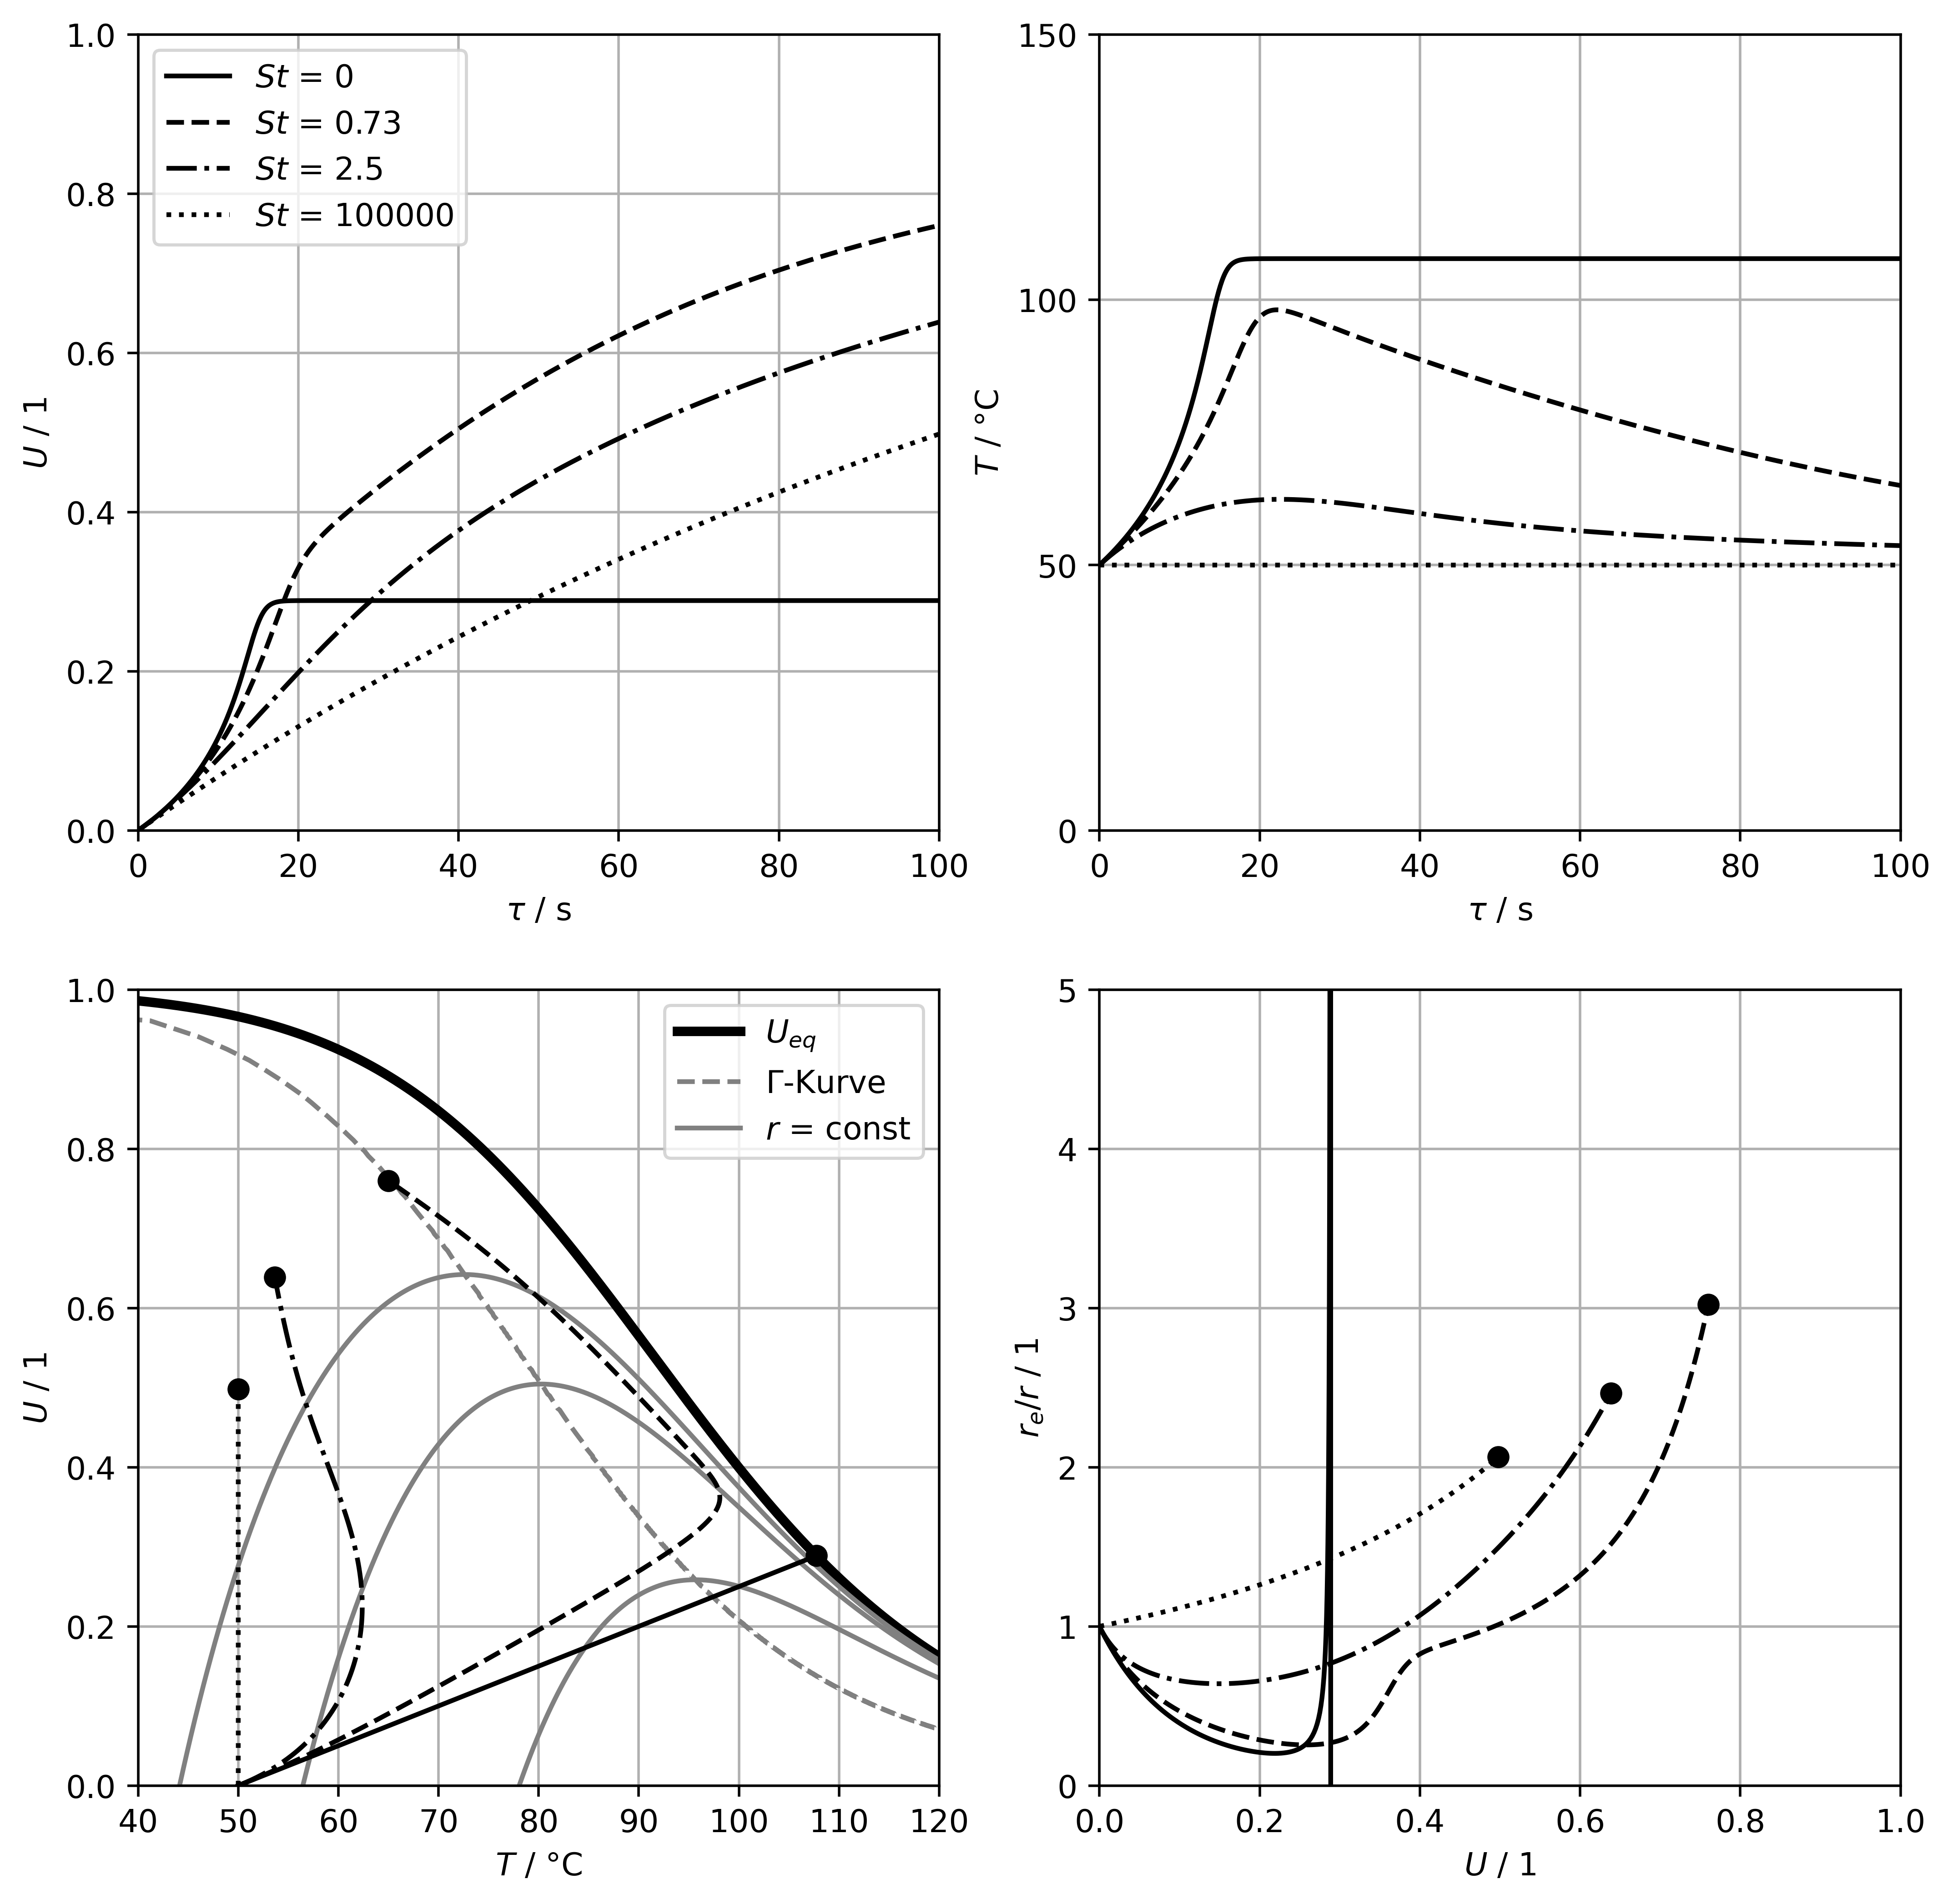

In [13]:
fig,axs = plt.subplots(2,2, figsize = (10,10), dpi = 500)

ls = ['solid', 'dashed', 'dashdot', 'dotted']

# oben links [0,0]
axs[0,0].set_xlabel('$\\tau$ / s')
axs[0,0].set_ylabel('$U$ / 1')
axs[0,0].set_xlim(0,100)
axs[0,0].set_ylim(0,1)
axs[0,0].grid(True)

counter = 0
for St in Stanton:
    axs[0,0].plot(t_save[counter], U_save[counter], label = (f'$St$ = {St}'), color = 'black', linestyle = ls[counter])
    counter = counter + 1
    
axs[0,0].legend(loc = 'upper left')

# oben rechts [0,1]
axs[0,1].set_xlabel('$\\tau$ / s')
axs[0,1].set_ylabel('$T$ / °C')
axs[0,1].set_xlim(0,100)
axs[0,1].set_ylim(0,150)
axs[0,1].set_yticks([0,50,100,150])
axs[0,1].grid(True)

counter = 0
for St in Stanton:
    axs[0,1].plot(t_save[counter], T_save[counter]-273, label = (f'$St$ = {St}'), color = 'black', linestyle = ls[counter])
    
    counter = counter + 1

# unten links [1,0]
axs[1,0].set_xlabel('$T$ / °C')
axs[1,0].set_ylabel('$U$ / 1')
axs[1,0].set_xlim(40, 120)
axs[1,0].set_ylim(0,1)
axs[1,0].grid(True)

axs[1,0].plot(T_range-273, U_eq(T_range), label = ('$U_{eq}$'), color = 'black', linewidth = 3)
axs[1,0].plot(T_gamma-273, gamma, label = ('$\Gamma$-Kurve'), color = 'grey', linestyle = 'dashed')
axs[1,0].plot(T_range-273, U_r(T_range, 5), color = 'grey', linestyle = 'solid', label = '$r$ = const')
axs[1,0].plot(T_range-273, U_r(T_range, 10), color = 'grey', linestyle = 'solid')
axs[1,0].plot(T_range-273, U_r(T_range, 30), color = 'grey', linestyle = 'solid')
axs[1,0].legend(loc = 'upper right')

counter = 0
for St in Stanton:
    axs[1,0].plot(T_save[counter]-273, U_save[counter], color = 'black', linestyle = ls[counter])
    
    T_dot = T_save[counter]
    U_dot = U_save[counter]
    axs[1,0].plot(T_dot[len(T_dot)-1]-273, U_dot[len(T_dot)-1], 'o', color = 'black')
    
    counter = counter + 1

# unten rechts [1,1]
axs[1,1].set_xlabel('$U$ / 1')
axs[1,1].set_ylabel('$r_e$/$r$ / 1')
axs[1,1].set_xlim(0,1)
axs[1,1].set_ylim(0,5)
axs[1,1].grid(True)

counter = 0
for St in Stanton:
    axs[1,1].plot(U_save[counter], RW(T_save[counter], U_save[counter]), color = 'black', linestyle = ls[counter])
    
    U_dot  = U_save[counter]
    RW_dot = RW(T_save[counter], U_save[counter])
    axs[1,1].plot(U_dot[len(U_dot)-1], RW_dot[len(U_dot)-1], 'o', color = 'black')
    
    counter = counter + 1
plt.show()

Eine detaillierte Interpretation der Grafik findet sich im Beispiel 11.3 des Lehrbuchs.